In [27]:
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
import datetime as dt
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
import os
from shutil import copy
import seaborn as sns
import scipy.stats as stats
import datetime
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import imageio
from itertools import compress

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams.update({'figure.max_open_warning': 0})

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
          'legend.title_fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
#‘xx-small’, ‘x-small’, ‘small’, ‘medium’, ‘large’, ‘x-large’, ‘xx-large’
pylab.rcParams.update(params)
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
# from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from statsmodels.tsa.api import VAR

from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn import tree

import re

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.stats import mannwhitneyu


In [3]:
df_smolt_data = pd.read_csv('data\\smolt_dataset.csv',delimiter=";")
# df_smolt_data = pd.read_csv('data\\smolt_dataset.csv')


df_smolt_data.insert(loc = 51, column = 'date_conf', value = np.nan)
df_smolt_data.reset_index(drop = True, inplace = True)
df_smolt_data ['transfer_date']= pd.to_datetime(df_smolt_data['transfer_date'],format='%d.%m.%Y')
df_smolt_data ['date_conf']= pd.to_datetime(df_smolt_data['date_conf'])                                                               
m = 0
while m < len(df_smolt_data):
    days_btw_transfer_conf = df_smolt_data.iloc[m] [50]
#     print('days_btw_transfer_conf', days_btw_transfer_conf)
    if np.isnan(days_btw_transfer_conf) == True:
        df_smolt_data.iloc[m] [51] = np.nan
    else:    
        transfer_date = df_smolt_data.iloc[m] ['transfer_date']
        df_smolt_data.at[m, 'date_conf'] = transfer_date - dt.timedelta(days = int(days_btw_transfer_conf))
    m = m + 1
    
#df_smolt_data.to_csv(r'/Users/evgenijnotebook/Desktop/Salmon_project/data/smolt_dataset_wth_date_conf.csv', index = False)  

In [4]:
for c in ['SGR','TGC','total_mortality_perc_90']:
    df_smolt_data[c] = df_smolt_data[c].str.replace(',', '.')
    df_smolt_data[c] = df_smolt_data[c].astype(float)

In [5]:
df_smolt_data = df_smolt_data.dropna(subset=['TGC'])
df_smolt_data = df_smolt_data.dropna(subset=['SGR'])
df_smolt_data = df_smolt_data.reset_index(drop=True)

In [6]:
temperatures=pd.read_csv("data\\FW_temperature_cleared.csv")
# temperatures.columns
# temperatures.head()
# temperatures[temperatures.final_locus_population_id.isin([36794892])]
# df_smolt_data['transfer_date'] = pd.to_datetime(df_smolt_data['transfer_date'])
# df_smolt_data['date_conf'] = pd.to_datetime(df_smolt_data['date_conf'])
temperatures['date'] = pd.to_datetime(temperatures['event_date'],format="%Y-%m-%d")

In [7]:
merged_df = df_smolt_data.merge(temperatures, left_on='from_locus_population_id', right_on='final_locus_population_id')

In [8]:
# grouped_df = merged_df.groupby('from_locus_population_id')

In [9]:
merged_df = df_smolt_data.merge(temperatures, left_on='from_locus_population_id', right_on='final_locus_population_id')

sums_by_id = {}
for group_id, group_data in merged_df.groupby('from_locus_population_id'):
    filtered_data = group_data[group_data.apply(lambda row: row['date'] <= row['transfer_date'] and row['date'] >= row['date_conf'], axis=1)]
    sum_of_tempr = filtered_data['rolling_tempr'].sum()
    sums_by_id[group_id] = sum_of_tempr
    
df_smolt_data = df_smolt_data.merge(pd.DataFrame({'from_locus_population_id': list(sums_by_id.keys()), 'rolling_tempr_sum': list(sums_by_id.values())}), on='from_locus_population_id', how='left')

In [10]:
# for group_id, sum_of_tempr in sums_by_id.items():
#     print(f"Sum of 'rolling_tempr' for group {group_id}: {sum_of_tempr}")

In [11]:
zero_count = (df_smolt_data['rolling_tempr_sum'] == 0).sum()
nan_count = df_smolt_data['rolling_tempr_sum'].isna().sum()

print("Number of zeros: ", zero_count)
print("Number of NaN values: ", nan_count)

Number of zeros:  0
Number of NaN values:  118


In [12]:
df_smolt_data = df_smolt_data[df_smolt_data['rolling_tempr_sum'] != 0]
df_smolt_data = df_smolt_data.dropna(subset=['rolling_tempr_sum'])
df_smolt_data = df_smolt_data.reset_index(drop=True)

In [13]:
#df_smolt_data.drop(['rolling_tempr_sum_x'], axis='columns', inplace=True)

In [14]:
df_smolt_data.columns

Index(['locus_id', 'fish_group_id', 'transfer_year', 'transfer_month',
       'transfer_month_year', 'transfer_season', 'total_count',
       'total_mortality_perc_90', 'transport_mortality_perc_90',
       'nontransport_mortality_perc_90', 'from_date', 'from_site_name',
       'from_site_id', 'from_locus_id', 'from_locus_population_id',
       'from_fish_group_id', 'from_fish_group_name', 'from_generation',
       'from_year_class', 'from_count_stocking', 'from_avg_weight', 'to_date',
       'type_id', 'to_site_name', 'to_site_id', 'to_locus_id',
       'to_locus_population_id', 'to_fish_group_id', 'to_fish_group_name',
       'to_generation', 'to_year_class', 'to_count_stocking', 'to_avg_weight',
       'transfer_date', 'from_fish_group_count', 'days_btw_to_from',
       'days_btw_to_transfer', 'vac_fish_count', 'vac_weight',
       'days_btw_conf_event', '00000000000SRSv/Pha ', '000IPN+AAA+VVV+ISA/Pha',
       'IPN+SRS+VIB+ASA+ISA/FAV', 'IPN+SRS+VVV+AAA+ISA/Pha',
       'IPN+SRS+VVV

In [15]:
#adding sw growth 90 days
df_transfers_sw_growth=pd.read_csv('data\\transfers_with_sw_growth_and_feed_first_90days.csv')
df=df_smolt_data.merge(df_transfers_sw_growth[['locus_id','fish_group_id','growth_90days']],how='left')
df['SGR_SW'] = 100*(df['growth_90days']**(1/90) - 1)
df['biomass_90days_1000fish_kg']=df['to_avg_weight']*df['growth_90days']*(1-df['total_mortality_perc_90'])*1000/1000

#adding SW temperature for TGC
df_sw_temp=pd.read_csv('data\\seawater_temperature__for_transfers_since_2017_only_first_90days_after_transfer_with_fish_group_id.csv')
df_sw_temp_grouped=df_sw_temp.groupby(['locus_id','to_fish_group_id']).temperature.sum().reset_index().rename(columns={'temperature':'degree_days_first_90days_after_transfer'})

df=df.merge(df_sw_temp_grouped, on=['locus_id','to_fish_group_id'],how='left')
df=df[df.degree_days_first_90days_after_transfer>=800]
df['avg_weight_90days'] = df['to_avg_weight']*df['growth_90days']
df['TGC_SW'] = 1000* ((df['avg_weight_90days']**(1/3)-df['to_avg_weight']**(1/3)) / df['degree_days_first_90days_after_transfer'])


# Strain - mortality

In [61]:
target = 'total_mortality_perc_90'

In [62]:
df=pd.read_csv("data\\smolt_dataset.csv", delimiter=';')

In [63]:
filtered_df = pd.DataFrame(columns=['strain', 'total_mortality_perc_90', 'group'])

# Assign group based on strain value
df['group'] = np.where(df['strain'].isin(['AQG']), 1, 0)

# Select required columns and copy to filtered_df
filtered_df[['strain', 'total_mortality_perc_90', 'group']] = df[['strain', 'total_mortality_perc_90', 'group']]

In [64]:
filtered_df['total_mortality_perc_90'] = filtered_df['total_mortality_perc_90'].str.replace(',', '.')
filtered_df['total_mortality_perc_90'] = filtered_df['total_mortality_perc_90'].astype(float)

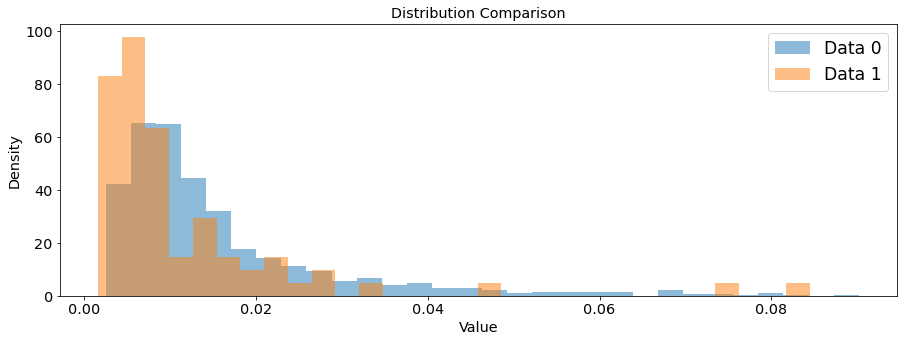

In [65]:
data0 = filtered_df[filtered_df['group'] == 0]['total_mortality_perc_90']
data1 = filtered_df[filtered_df['group'] == 1]['total_mortality_perc_90']
plt.hist(data0, bins=30, alpha=0.5, label='Data 0', density=True)
plt.hist(data1, bins=30, alpha=0.5, label='Data 1', density=True)

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution Comparison')
plt.legend()

plt.show()

In [70]:
mean_values = filtered_df.groupby('group')[target].mean()
median_values = filtered_df.groupby('group')[target].median()
# mode_values = df.groupby('group')[target].agg(pd.Series.mode)
min_values = filtered_df.groupby('group')[target].min()
max_values = filtered_df.groupby('group')[target].max()
# Print the results
print("Mean values:")
print(mean_values)
print("\nMedian values:")
print(median_values)
# print("\nMode values:")
# print(mode_values)
print("\nMinimum values:")
print(min_values)
print("\nMaximum values:")
print(max_values)

Mean values:
group
0    0.015590
1    0.011806
Name: total_mortality_perc_90, dtype: float64

Median values:
group
0    0.011204
1    0.007329
Name: total_mortality_perc_90, dtype: float64

Minimum values:
group
0    0.002496
1    0.001601
Name: total_mortality_perc_90, dtype: float64

Maximum values:
group
0    0.090181
1    0.084519
Name: total_mortality_perc_90, dtype: float64


In [75]:
num_samples=10000
sample_size=20
p_values=[]
u_stats=[]
for i in range(num_samples):
    sample0 = np.random.choice(data0, size=sample_size, replace=True)
    sample1 = np.random.choice(data1, size=sample_size, replace=True)
#     statistic, p_value = mannwhitneyu(sample0, sample1, alternative='two-sided')
    statistic, p_value = mannwhitneyu(sample0, sample1, alternative='less')
    p_values.append(p_value)
    u_stats.append(statistic)
    #print("Mann-Whitney U statistic: ", statistic)
    #print("P-Value: ", p_value)

In [76]:
#critical value for U-stats with sample size(20,20)=138
passed_count=0
for i in range (0,len(u_stats)):    
    if p_values[i]<=0.05 and u_stats[i]<=138:
        passed_count=passed_count+1
print("Number of tests passed=",passed_count,"/",num_samples,"tests runned")

Number of tests passed= 0 / 10000 tests runned


# TGC vs TGC_SW

In [23]:
target = 'TGC_SW'
# factor = 'SGR'
factor = 'TGC'

correlation = df[factor].corr(df[target])
print("Correlation between TGC and TGC_SW:", correlation)

Correlation between TGC and TGC_SW: 0.05717909644316831


In [19]:
df = df.dropna(subset=[factor])
df = df.reset_index(drop=True)

In [20]:
median_sgr = df[factor].median()
df['group'] = np.where(df[factor] < median_sgr, 0, 1)

In [21]:
df=df[df.TGC_SW>1]
df=df[df.TGC<2]

<AxesSubplot:xlabel='TGC_SW', ylabel='TGC'>

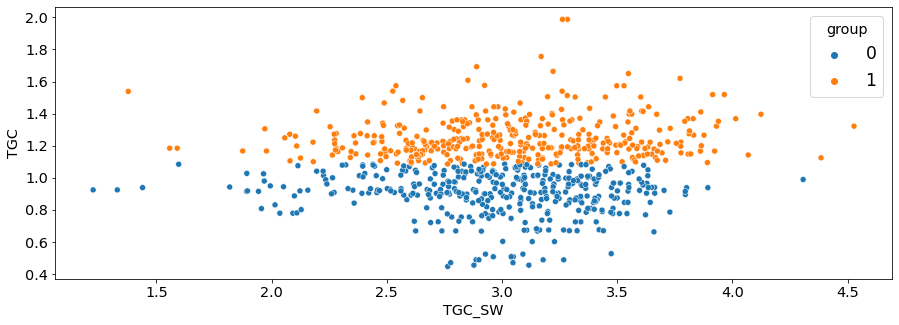

In [22]:
sns.scatterplot(data=df, x=target, y=factor, hue='group')

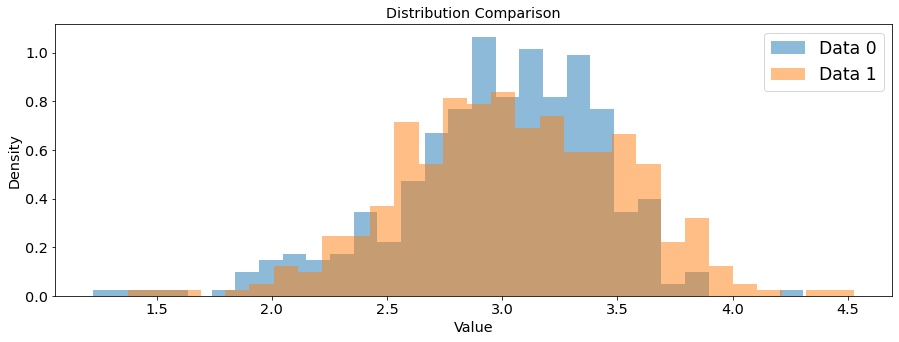

In [24]:
data0 = df[df['group'] == 0][target]
data1 = df[df['group'] == 1][target]
plt.hist(data0, bins=30, alpha=0.5, label='Data 0', density=True)
plt.hist(data1, bins=30, alpha=0.5, label='Data 1', density=True)

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution Comparison')
plt.legend()

plt.show()

In [25]:
mean_values = df.groupby('group')[target].mean()
median_values = df.groupby('group')[target].median()
# mode_values = df.groupby('group')[target].agg(pd.Series.mode)
min_values = df.groupby('group')[target].min()
max_values = df.groupby('group')[target].max()
# Print the results
print("Mean values:")
print(mean_values)
print("\nMedian values:")
print(median_values)
# print("\nMode values:")
# print(mode_values)
print("\nMinimum values:")
print(min_values)
print("\nMaximum values:")
print(max_values)


Mean values:
group
0    2.980670
1    3.047373
Name: TGC_SW, dtype: float64

Median values:
group
0    3.033138
1    3.039175
Name: TGC_SW, dtype: float64

Minimum values:
group
0    1.225386
1    1.377767
Name: TGC_SW, dtype: float64

Maximum values:
group
0    4.306993
1    4.527957
Name: TGC_SW, dtype: float64


In [38]:
num_samples=10000
sample_size=20
p_values=[]
u_stats=[]
for i in range(num_samples):
    sample0 = np.random.choice(data0, size=sample_size, replace=True)
    sample1 = np.random.choice(data1, size=sample_size, replace=True)
    statistic, p_value = mannwhitneyu(sample0, sample1, alternative='two-sided')
    p_values.append(p_value)
    u_stats.append(statistic)
    #print("Mann-Whitney U statistic: ", statistic)
    #print("P-Value: ", p_value)

In [39]:
#critical value for U-stats with sample size(20,20)=138
passed_count=0
for i in range (0,len(u_stats)):    
    if p_values[i]<=0.05 and u_stats[i]<=138:
        passed_count=passed_count+1
print("Number of tests passed=",passed_count,"/",num_samples,"tests runned")

Number of tests passed= 478 / 10000 tests runned


# SGR

In [28]:
correlation = df_smolt_data['SGR'].corr(df_smolt_data['total_mortality_perc_90'])

print("Correlation between SGR and total_mortality_perc_90:", correlation)

Correlation between SGR and total_mortality_perc_90: -0.08136528914377135


In [29]:
df_smolt_data = df_smolt_data.dropna(subset=['SGR'])

df_smolt_data = df_smolt_data.reset_index(drop=True)

In [30]:
median_sgr = df_smolt_data['SGR'].median()


df_smolt_data['group'] = np.where(df_smolt_data['SGR'] < median_sgr, 0, 1)

In [34]:
# df_smolt_data.groupby('group')['locus_id'].count()

group
0    408
1    408
Name: locus_id, dtype: int64

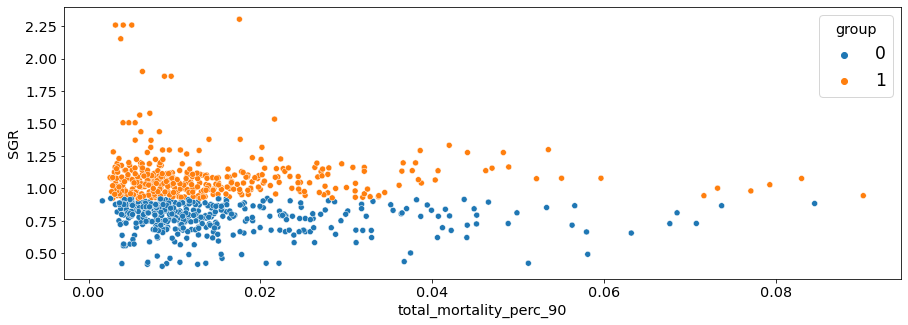

In [36]:
sns.scatterplot(data=df_smolt_data, x='total_mortality_perc_90', y='SGR', hue='group')

In [38]:
# df_smolt_data['total_mortality_perc_90'] = pd.to_numeric(df_smolt_data['total_mortality_perc_90'], errors='coerce')
df_smolt_data['total_mortality_perc_90'] = pd.to_numeric(df_smolt_data['total_mortality_perc_90'])

In [40]:
group_0 = df_smolt_data[df_smolt_data['group'] == 0]['total_mortality_perc_90']
group_1 = df_smolt_data[df_smolt_data['group'] == 1]['total_mortality_perc_90']

sample_std = np.std(group_0, ddof=1) 

n = len(group_0)  
population_std = sample_std * np.sqrt(n / (n - 1))

In [42]:
sample_std,population_std

(0.01299202487810654, 0.013007975804774473)

In [44]:
import statsmodels.api as sm
from statsmodels.stats.weightstats import ztest

group_0 = df_smolt_data[df_smolt_data['group'] == 0]['total_mortality_perc_90']
group_1 = df_smolt_data[df_smolt_data['group'] == 1]['total_mortality_perc_90']

#?
# population_std = 0.013306602967795473  

z_statistic, p_value = ztest(group_0, group_1, value=0, alternative='two-sided', usevar='pooled', ddof=0)

# Print the z-statistic and p-value
print("Z-Statistic: ", z_statistic)
print("P-Value: ", p_value)

Z-Statistic:  1.3496870664971277
P-Value:  0.17711638271199626


In [509]:
# import statsmodels.api as sm
# from statsmodels.stats.weightstats import ztest

# group_0 = df_smolt_data[df_smolt_data['group'] == 0]['total_mortality_perc_90']
# group_1 = df_smolt_data[df_smolt_data['group'] == 1]['total_mortality_perc_90']

# #?
# # population_std = 0.013306602967795473  

# z_statistic, p_value = ztest(group_0, group_1, value=0, alternative='two-sided', usevar='pooled', ddof=0)

# # Print the z-statistic and p-value
# print("Z-Statistic: ", z_statistic)
# print("P-Value: ", p_value)

Z-Statistic:  1.1383337679930507
P-Value:  0.2549811387330352


In [ ]:
#Z-test failed and non valid due to distribution form

In [48]:
group_0 = df_smolt_data[df_smolt_data['group'] == 0]['total_mortality_perc_90']
group_1 = df_smolt_data[df_smolt_data['group'] == 1]['total_mortality_perc_90']
group_0 = np.nan_to_num(group_0)
group_1 = np.nan_to_num(group_1)

#t_statistic, p_value = stats.ttest_ind(group_0, group_1)


#print("T-Statistic: ", t_statistic)
#print("P-Value: ", p_value)

In [50]:
# group_0 = df_smolt_data[df_smolt_data['group'] == 0]['total_mortality_perc_90']
# group_1 = df_smolt_data[df_smolt_data['group'] == 1]['total_mortality_perc_90']

# # Run t-test
# t_statistic, p_value = stats.ttest_ind(group_0, group_1)

# # Print the t-statistic and p-value
# print("T-Statistic: ", t_statistic)
# print("P-Value: ", p_value)

T-Statistic:  1.348032023487711
P-Value:  0.17802308918208212


In [514]:
#T-test failed and non valid due to distribution form

SyntaxError: invalid syntax (<ipython-input-514-41ea2a82d2a0>, line 1)

In [51]:

group_0 = df_smolt_data[df_smolt_data['group'] == 0]['total_mortality_perc_90']
group_1 = df_smolt_data[df_smolt_data['group'] == 1]['total_mortality_perc_90']

statistic, p_value = mannwhitneyu(group_0, group_1, alternative='two-sided')

print("Mann-Whitney U statistic: ", statistic)
print("P-Value: ", p_value)

Mann-Whitney U statistic:  91022.0
P-Value:  0.020677760077569676


In [515]:
# from scipy.stats import mannwhitneyu

# group_0 = df_smolt_data[df_smolt_data['group'] == 0]['total_mortality_perc_90']
# group_1 = df_smolt_data[df_smolt_data['group'] == 1]['total_mortality_perc_90']

# statistic, p_value = mannwhitneyu(group_0, group_1, alternative='two-sided')

# print("Mann-Whitney U statistic: ", statistic)
# print("P-Value: ", p_value)

Mann-Whitney U statistic:  70121.0
P-Value:  0.040953929796124264


In [52]:
mean_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].mean()
median_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].median()
#mode_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].agg(pd.Series.mode)
min_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].min()
max_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].max()
# Print the results
print("Mean values:")
print(mean_values)
print("\nMedian values:")
print(median_values)
#print("\nMode values:")
#print(mode_values)
print("\nMinimum values:")
print(min_values)
print("\nMaximum values:")
print(max_values)


Mean values:
group
0    0.015380
1    0.014155
Name: total_mortality_perc_90, dtype: float64

Median values:
group
0    0.010950
1    0.009616
Name: total_mortality_perc_90, dtype: float64

Minimum values:
group
0    0.001601
1    0.002496
Name: total_mortality_perc_90, dtype: float64

Maximum values:
group
0    0.084519
1    0.090181
Name: total_mortality_perc_90, dtype: float64


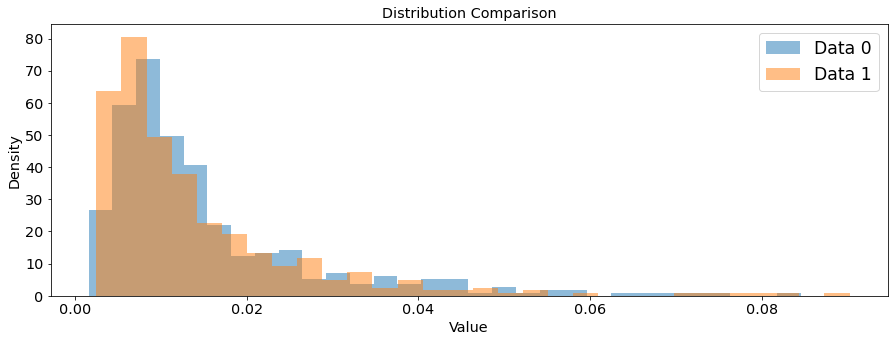

In [53]:
data0 = df_smolt_data[df_smolt_data['group'] == 0]['total_mortality_perc_90']
data1 = df_smolt_data[df_smolt_data['group'] == 1]['total_mortality_perc_90']
plt.hist(data0, bins=30, alpha=0.5, label='Data 0', density=True)
plt.hist(data1, bins=30, alpha=0.5, label='Data 1', density=True)

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution Comparison')
plt.legend()

plt.show()

In [54]:
data0 = df_smolt_data[df_smolt_data['group'] == 0]['total_mortality_perc_90']

In [55]:
sample_mean = data0.mean()
sample_std = data0.std()

In [56]:
sample_means0 = []
num_samples=3000
sample_size=30
for i in range(num_samples):
    sample = np.random.choice(data0, size=sample_size, replace=True)
    sample_means0.append(sample.mean())

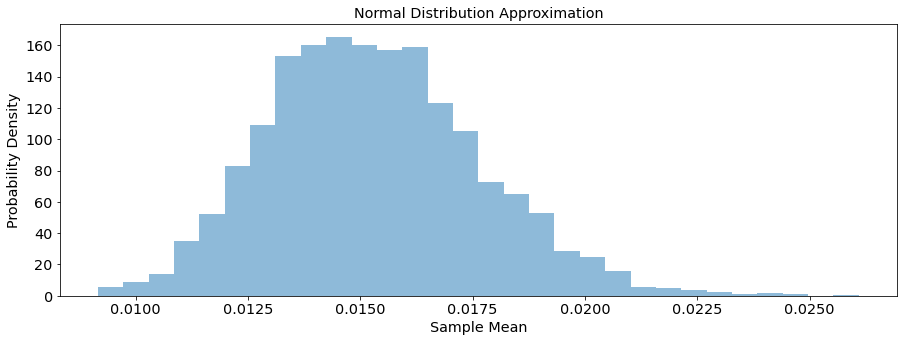

In [57]:
plt.hist(sample_means0, bins=30, density=True, alpha=0.5)
plt.xlabel('Sample Mean')
plt.ylabel('Probability Density')
plt.title('Normal Distribution Approximation')
plt.show()

In [62]:
data1 = df_smolt_data[df_smolt_data['group'] == 1]['total_mortality_perc_90']

In [63]:
sample_mean = data1.mean()
sample_std = data1.std()

In [64]:
sample_means1 = []
num_samples=3000
sample_size=30
for i in range(num_samples):
    sample = np.random.choice(data1, size=sample_size, replace=True)
    sample_means1.append(sample.mean())

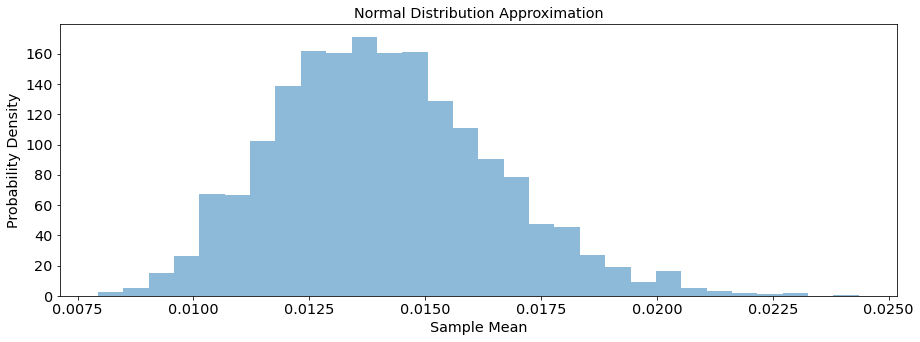

In [65]:
plt.hist(sample_means1, bins=30, density=True, alpha=0.5)
plt.xlabel('Sample Mean')
plt.ylabel('Probability Density')
plt.title('Normal Distribution Approximation')
plt.show()

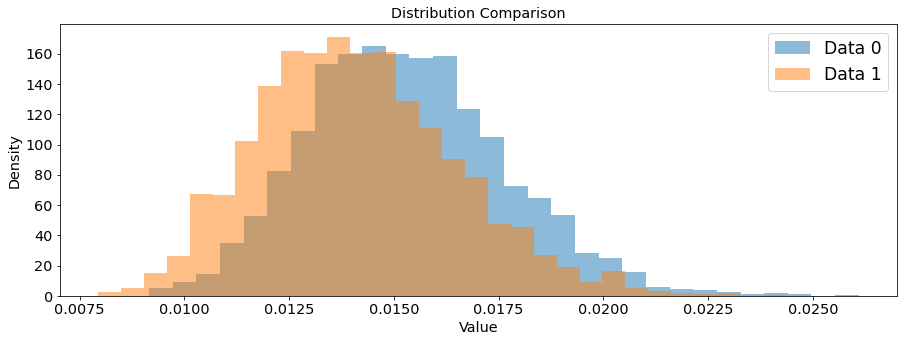

In [66]:
plt.hist(sample_means0, bins=30, alpha=0.5, label='Data 0', density=True)
plt.hist(sample_means1, bins=30, alpha=0.5, label='Data 1', density=True)

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution Comparison')
plt.legend()

plt.show()

In [68]:
group_0 = sample_means0
group_1 = sample_means1

# Run t-test
t_statistic, p_value = stats.ttest_ind(group_0, group_1)

# Print the t-statistic and p-value
print("T-Statistic: ", t_statistic)
print("P-Value: ", p_value)

T-Statistic:  19.592469442387046
P-Value:  6.69413987343033e-83


# SGR filtered

In [69]:
sorted_df = df_smolt_data.sort_values('rolling_tempr_sum')
exclude_rows = int(len(sorted_df) * 0.25)
filtered_df = sorted_df.iloc[exclude_rows:-exclude_rows]
filtered_df = filtered_df.reset_index(drop=True)

In [70]:
df_smolt_data=filtered_df

In [71]:
# df_smolt_data['SGR'] = df_smolt_data['SGR'].str.replace(',', '.')
# df_smolt_data['SGR'] = df_smolt_data['SGR'].astype(float)
# df_smolt_data['total_mortality_perc_90'] = df_smolt_data['total_mortality_perc_90'].str.replace(',', '.')
# df_smolt_data['total_mortality_perc_90'] = df_smolt_data['total_mortality_perc_90'].astype(float)

AttributeError: Can only use .str accessor with string values!

In [75]:
# correlation = df_smolt_data['SGR'].corr(df_smolt_data['total_mortality_perc_90'])

# print("Correlation between SGR and total_mortality_perc_90:", correlation)

Correlation between SGR and total_mortality_perc_90: -0.01557235123649832


In [76]:
df_smolt_data = df_smolt_data.dropna(subset=['SGR'])
df_smolt_data = df_smolt_data.reset_index(drop=True)

In [77]:
median_sgr = df_smolt_data['SGR'].median()
df_smolt_data['group'] = np.where(df_smolt_data['SGR'] < median_sgr, 0, 1)

<AxesSubplot:xlabel='total_mortality_perc_90', ylabel='SGR'>

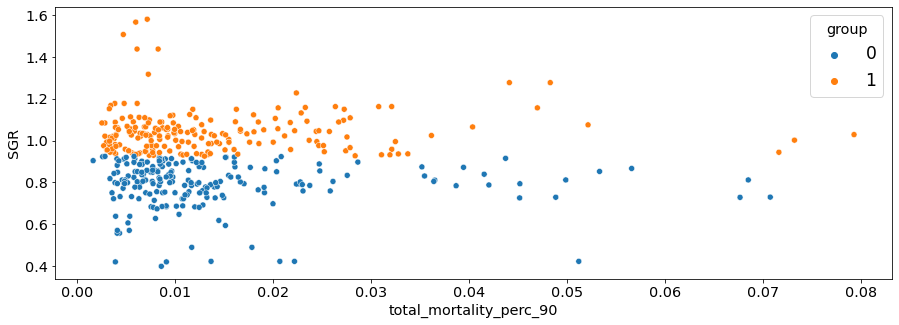

In [78]:
sns.scatterplot(data=df_smolt_data, x='total_mortality_perc_90', y='SGR', hue='group')

In [79]:
group_0 = df_smolt_data[df_smolt_data['group'] == 0]['total_mortality_perc_90']
group_1 = df_smolt_data[df_smolt_data['group'] == 1]['total_mortality_perc_90']

statistic, p_value = mannwhitneyu(group_0, group_1, alternative='two-sided')

print("Mann-Whitney U statistic: ", statistic)
print("P-Value: ", p_value)

Mann-Whitney U statistic:  21308.0
P-Value:  0.674919683318967


In [80]:
mean_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].mean()
median_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].median()
#mode_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].agg(pd.Series.mode)
min_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].min()
max_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].max()
# Print the results
print("Mean values:")
print(mean_values)
print("\nMedian values:")
print(median_values)
#print("\nMode values:")
#print(mode_values)
print("\nMinimum values:")
print(min_values)
print("\nMaximum values:")
print(max_values)

Mean values:
group
0    0.014059
1    0.013852
Name: total_mortality_perc_90, dtype: float64

Median values:
group
0    0.009659
1    0.009766
Name: total_mortality_perc_90, dtype: float64

Minimum values:
group
0    0.001601
1    0.002496
Name: total_mortality_perc_90, dtype: float64

Maximum values:
group
0    0.070746
1    0.079301
Name: total_mortality_perc_90, dtype: float64


# SGR + Sampling

In [37]:
# from scipy.stats import mannwhitneyu

In [83]:
correlation = df_smolt_data['SGR'].corr(df_smolt_data['total_mortality_perc_90'])
print("Correlation between SGR and total_mortality_perc_90:", correlation)

Correlation between SGR and total_mortality_perc_90: -0.01557235123649832


In [84]:
df_smolt_data = df_smolt_data.dropna(subset=['SGR'])
df_smolt_data = df_smolt_data.reset_index(drop=True)
median_sgr = df_smolt_data['SGR'].median()
df_smolt_data['group'] = np.where(df_smolt_data['SGR'] < median_sgr, 0, 1)
df_smolt_data['total_mortality_perc_90'] = pd.to_numeric(df_smolt_data['total_mortality_perc_90'], errors='coerce')

In [85]:
data1 = df_smolt_data[df_smolt_data['group'] == 1]['total_mortality_perc_90']
data0 = df_smolt_data[df_smolt_data['group'] == 0]['total_mortality_perc_90']

In [86]:
sample_mean = data1.mean()
sample_std = data1.std()

In [87]:
num_samples=5000
sample_size=20
p_values=[]
u_stats=[]
for i in range(num_samples):
    sample0 = np.random.choice(data0, size=sample_size, replace=True)
    sample1 = np.random.choice(data1, size=sample_size, replace=True)
    statistic, p_value = mannwhitneyu(sample0, sample1, alternative='two-sided')
    p_values.append(p_value)
    u_stats.append(statistic)
    #print("Mann-Whitney U statistic: ", statistic)
    #print("P-Value: ", p_value)

(array([2.33463035e-05, 7.00389105e-05, 4.66926070e-05, 4.66926070e-05,
        3.03501946e-04, 6.07003891e-04, 9.33852140e-04, 1.72762646e-03,
        2.70817121e-03, 3.71206226e-03, 4.97276265e-03, 6.32684825e-03,
        8.77821012e-03, 9.08171206e-03, 1.06459144e-02, 1.14163424e-02,
        1.04357977e-02, 1.01789883e-02, 8.66147860e-03, 8.26459144e-03,
        5.01945525e-03, 4.87937743e-03, 3.12840467e-03, 2.03112840e-03,
        1.35408560e-03, 6.07003891e-04, 3.96887160e-04, 1.63424125e-04,
        1.63424125e-04, 4.66926070e-05]),
 array([ 83.        ,  91.56666667, 100.13333333, 108.7       ,
        117.26666667, 125.83333333, 134.4       , 142.96666667,
        151.53333333, 160.1       , 168.66666667, 177.23333333,
        185.8       , 194.36666667, 202.93333333, 211.5       ,
        220.06666667, 228.63333333, 237.2       , 245.76666667,
        254.33333333, 262.9       , 271.46666667, 280.03333333,
        288.6       , 297.16666667, 305.73333333, 314.3       ,
      

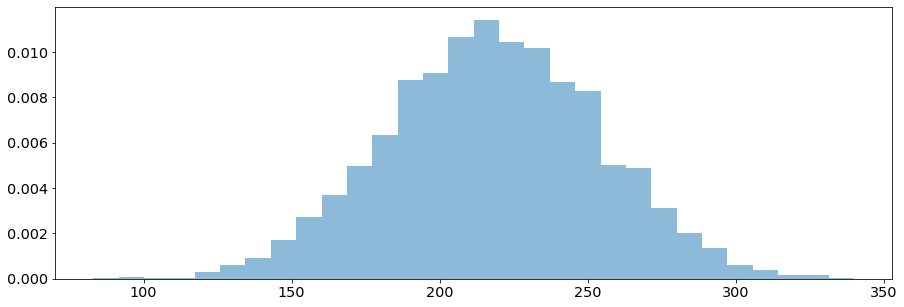

In [62]:
plt.hist(u_stats, bins=30, density=True, alpha=0.5)

(array([0.9803674 , 1.04839289, 1.05039364, 0.98837039, 0.93034865,
        1.08440638, 1.04038989, 0.94635465, 0.76428642, 1.17043862]),
 array([3.74752389e-04, 1.00337277e-01, 2.00299802e-01, 3.00262327e-01,
        4.00224851e-01, 5.00187376e-01, 6.00149901e-01, 7.00112426e-01,
        8.00074950e-01, 9.00037475e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

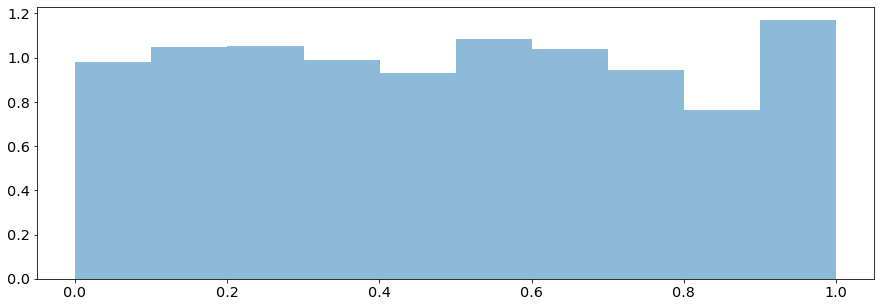

In [92]:
# plt.hist(p_values, alpha=0.5, density=True)

In [93]:
#critical value for U-stats with sample size(20,20)=138
passed_count=0
for i in range (0,len(u_stats)):    
    if p_values[i]<=0.05 and u_stats[i]<=138:
        passed_count=passed_count+1
print("Number of tests passed=",passed_count,"/",num_samples,"tests runned")

Number of tests passed= 88 / 5000 tests runned


# DE

In [257]:
# xfactor='SGR'
xfactor='TGC'
# xfactor='rolling_tempr_sum'


median_factor = df_smolt_data[xfactor].median()
df_smolt_data['group'] = np.where(df_smolt_data[xfactor] < median_factor, 0, 1)

In [258]:
df_smolt_data[xfactor].median()

1.0794824715

<AxesSubplot:xlabel='total_mortality_perc_90', ylabel='TGC'>

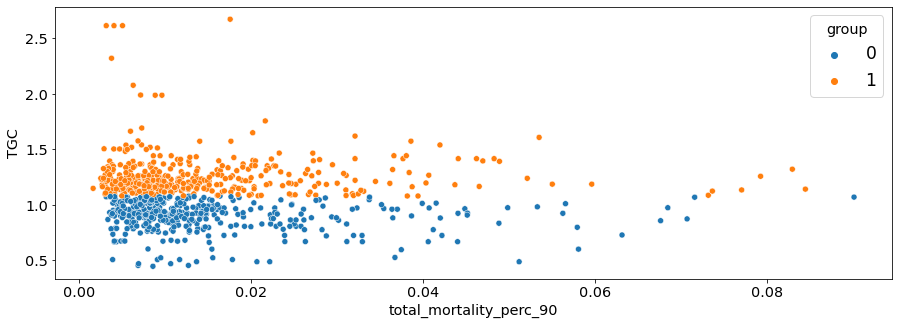

In [259]:
sns.scatterplot(data=df_smolt_data, x='total_mortality_perc_90', y=xfactor, hue='group')

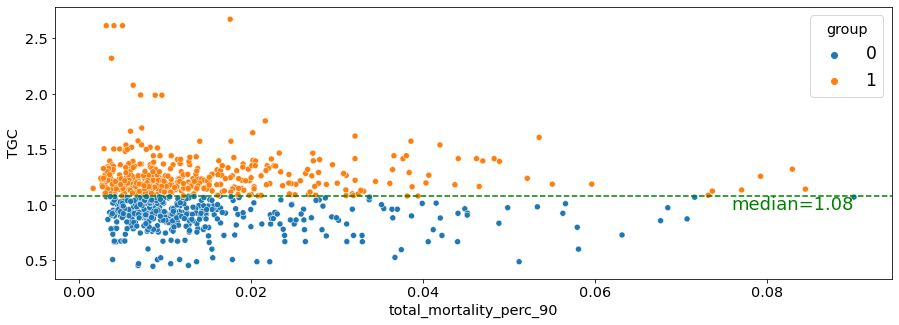

In [272]:
df_smolt_data_filtered=df_smolt_data[df_smolt_data['rolling_tempr_sum']<6000]
# df_smolt_data_filtered=df_smolt_data_filtered[df_smolt_data_filtered.rolling_tempr_sum.between(900,1100)]
# df_smolt_data_filtered=df_smolt_data_filtered[df_smolt_data_filtered.rolling_tempr_sum.between(1200,1500)]

# df_smolt_data_filtered=df_smolt_data_filtered[df_smolt_data_filtered.rolling_tempr_sum.between(900,1100)]

# Scatter plot
scatter_plot = sns.scatterplot(data=df_smolt_data_filtered, x='total_mortality_perc_90', y=xfactor, hue='group')

# Calculate the median of the 'TGC' column
median_value = df_smolt_data_filtered['TGC'].median()

# Add horizontal dashed line
scatter_plot.axhline(median_value, linestyle='--', color='green')

# Add text label
scatter_plot.text(df_smolt_data_filtered['total_mortality_perc_90'].max(), median_value, f"median={median_value:.2f}", color='green',fontsize=18, ha='right', va='top')

# Display the plot
# plt.show()
plt.savefig('TGC_vs_mortality_hypo1.png')

In [248]:
group_0 = df_smolt_data_filtered[df_smolt_data_filtered['group'] == 0]['total_mortality_perc_90']
group_1 = df_smolt_data_filtered[df_smolt_data_filtered['group'] == 1]['total_mortality_perc_90']
group_0 = np.nan_to_num(group_0)
group_1 = np.nan_to_num(group_1)

sample_std = np.std(group_0, ddof=1) 

n = len(group_0)  
population_std = sample_std * np.sqrt(n / (n - 1))

In [140]:
# import statsmodels.api as sm
# from statsmodels.stats.weightstats import ztest

# population_std = sample_std 

# z_statistic, p_value = ztest(group_0, group_1, value=0, alternative='two-sided', usevar='pooled', ddof=0)

# # Print the z-statistic and p-value
# print("Z-Statistic: ", z_statistic)
# print("P-Value: ", p_value)

Z-Statistic:  0.4278299636154593
P-Value:  0.6687749201548092


In [141]:
# # Run t-test
# t_statistic, p_value = stats.ttest_ind(group_0, group_1)

# # Print the t-statistic and p-value
# print("T-Statistic: ", t_statistic)
# print("P-Value: ", p_value)

T-Statistic:  0.4273053405320223
P-Value:  0.669269949490392


In [142]:
# group_0 = df_smolt_data[df_smolt_data['group'] == 0]['total_mortality_perc_90']
# group_1 = df_smolt_data[df_smolt_data['group'] == 1]['total_mortality_perc_90']

# statistic, p_value = mannwhitneyu(group_0, group_1, alternative='two-sided')

# print("Mann-Whitney U statistic: ", statistic)
# print("P-Value: ", p_value)

Mann-Whitney U statistic:  87647.0
P-Value:  0.18975755617226275


In [249]:
mean_values = df_smolt_data_filtered.groupby('group')['total_mortality_perc_90'].mean()
median_values = df_smolt_data_filtered.groupby('group')['total_mortality_perc_90'].median()
#mode_values = df_smolt_data.groupby('group')['total_mortality_perc_90'].agg(pd.Series.mode)
min_values = df_smolt_data_filtered.groupby('group')['total_mortality_perc_90'].min()
max_values = df_smolt_data_filtered.groupby('group')['total_mortality_perc_90'].max()
# Print the results
print("Mean values:")
print(mean_values)
print("\nMedian values:")
print(median_values)
#print("\nMode values:")
#print(mode_values)
print("\nMinimum values:")
print(min_values)
print("\nMaximum values:")
print(max_values)

Mean values:
group
0    0.013893
1    0.015396
Name: total_mortality_perc_90, dtype: float64

Median values:
group
0    0.009889
1    0.010435
Name: total_mortality_perc_90, dtype: float64

Minimum values:
group
0    0.002648
1    0.001601
Name: total_mortality_perc_90, dtype: float64

Maximum values:
group
0    0.077095
1    0.090181
Name: total_mortality_perc_90, dtype: float64


In [250]:
num_samples=5000
sample_size=20
p_values=[]
u_stats=[]
for i in range(num_samples):
    sample0 = np.random.choice(group_0, size=sample_size, replace=True)
    sample1 = np.random.choice(group_1, size=sample_size, replace=True)
    statistic, p_value = mannwhitneyu(sample0, sample1, alternative='two-sided')
    p_values.append(p_value)
    u_stats.append(statistic)
    #print("Mann-Whitney U statistic: ", statistic)
    #print("P-Value: ", p_value)

(array([0.0001  , 0.0001  , 0.000225, 0.000675, 0.0011  , 0.00175 ,
        0.002675, 0.003425, 0.0048  , 0.0061  , 0.006675, 0.0089  ,
        0.0093  , 0.010725, 0.0108  , 0.01085 , 0.00955 , 0.008425,
        0.0073  , 0.00595 , 0.004575, 0.003525, 0.0026  , 0.001875,
        0.00125 , 0.000775, 0.00035 , 0.000325, 0.0002  , 0.0001  ]),
 array([ 74.,  82.,  90.,  98., 106., 114., 122., 130., 138., 146., 154.,
        162., 170., 178., 186., 194., 202., 210., 218., 226., 234., 242.,
        250., 258., 266., 274., 282., 290., 298., 306., 314.]),
 <BarContainer object of 30 artists>)

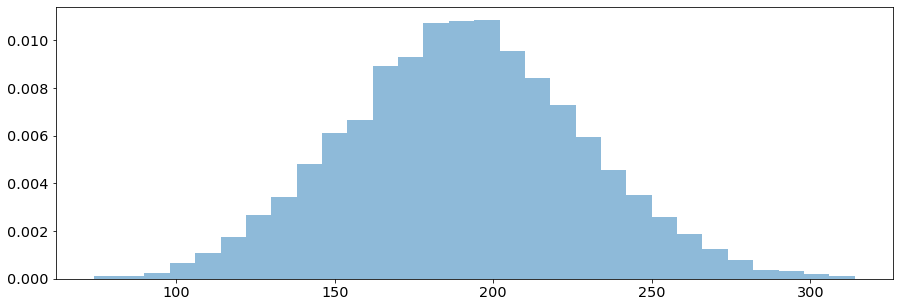

In [243]:
# plt.hist(u_stats, bins=30, density=True, alpha=0.5)

In [274]:
pd.DataFrame(u_stats).mean()

0    194.2331
dtype: float64

In [251]:
#critical value for U-stats with sample size(20,20)=138
critical_value_n20=138
p_value_max = 0.05
passed_count=0
for i in range (0,len(u_stats)):    
    if p_values[i]<=p_value_max and u_stats[i]<=critical_value_n20:
        passed_count=passed_count+1
print("Number of tests passed=",passed_count,"/",num_samples,"tests runned")

Number of tests passed= 172 / 5000 tests runned


In [49]:
# temperatures['event_date'] = pd.to_datetime(temperatures['event_date'], format='%d.%m.%Y')

# # Filter the dataframe based on the conditions
# filtered_temperatures = temperatures[(temperatures['final_locus_population_id'] == 36794095) &
#                                     (temperatures['event_date'] >= pd.to_datetime('27.09.2019', format='%d.%m.%Y')) &
#                                     (temperatures['event_date'] <= pd.to_datetime('04.01.2020', format='%d.%m.%Y'))]

# # Calculate the sum of rolling_tempr column in the filtered dataframe
# sum_rolling_tempr = filtered_temperatures['rolling_tempr'].sum()
